# AI Developer’s Guide: Efficient Vector Search in MongoDB Atlas with Automatic Quantization and Voyage AI Embeddings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/techniques/evaluation_of_representation_capacity_retention_with_mongodb_voyageai.ipynb.ipynb)

---

## Introduction
What's included in this notebook?

- Data loading and preparation
- Vector search index creation
- Data ingestion
- Vector search operation
- Retrieving documents and analysing results
- Representational Capacity Retention
- Evaluating metrics such as recall, retention, and latency
- Visualizing search performance and trade-offs

Glossary:
- Vector Search: A technique used to search for documents in a vector database by comparing the query vector to the vectors in the database.
- Embedding: A vector representation of a text or image.
- Quantization: A technique used to reduce the precision of a vector by converting it to a lower precision.
- ENN: Exact Nearest Neighbour
- ANN: Approximate Nearest Neighbour
- Float32: A floating point number with 32 bits.
- Scalar Quantization: A technique used to reduce the precision of a vector by converting it to a lower precision.
- Binary Quantization: A technique used to reduce the precision of a vector by converting it to a lower precision.
- Representational Capacity Retention: The ability of a vector to retain the information of the original vector.

In this guide, we demonstrate how to leverage MongoDB Atlas Search with automatic quantization and Voyage AI embeddings to build a scalable, high-performance vector search pipeline. 

By compressing the embedding space—whether through scalar or binary quantization—you can dramatically reduce memory usage while retaining the vast majority of retrieval accuracy compared to a float32 baseline. 

These techniques not only cut operational costs but also improve throughput, allowing you to handle larger workloads or more complex queries. 

Furthermore, MongoDB Atlas’s integration of indexing, querying, and storage provides a unified environment for rapid prototyping, testing, and production deployment, all backed by robust, enterprise-ready infrastructure.








## Step 1: Importing Libraries

Install the necessary libraries for the notebook
- pymongo: MongoDB Python driver, this will be used to connect to the MongoDB Atlas cluster.
- voyageai: Voyage AI Python client. This will be used to generate the embeddings for the wikipedia data.
- pandas: Data manipulation and analysis, this will be used to load the wikipedia data and prepare it for the vector search.
- datasets: Load and manage datasets, this will be used to load the wikipedia data.
- matplotlib: Plotting and visualizing data, this will be used to visualize the data.


In [ ]:
%pip install --quiet -U pymongo voyageai pandas datasets matplotlib

Creating the function `set_env_securely` to securely get and set environment variables. This is a helper function to get and set environment variables securely.

In [23]:
import getpass
import os


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

## Step 2: Data Loading and Preparation



The dataset used in this notebook is the [wikipedia-22-12-en-voyage-embed](https://huggingface.co/datasets/RichmondMongo/wikipedia-22-12-en-voyage-embed) dataset. 
This dataset contains the wikipedia data with the embeddings for each document.

The structure of the dataset is as follows:
```

{
  "_id": {
    "$oid": "67b850ebf6f7ad9038cd4ece"
  },
  "id": 1,
  "title": "YouTube",
  "text": "YouTube is a global online video sharing and social media platform headquartered in San Bruno, California. It was launched on February 14, 2005, by Steve Chen, Chad Hurley, and Jawed Karim ... videos were being uploaded at a rate of more than 500 hours of content per minute.",
  "url": "https://en.wikipedia.org/wiki?curid=3524766",
  "wiki_id": 3524766,
  "views": 5409.56103515625,
  "paragraph_id": 0,
  "langs": 184,
  "embedding": [
    -0.027068108320236206,
    0.023762645199894905,
    ...
    0.002724801190197468,
    -0.003213807474821806,
    0.025735605508089066
  ]
}

```

- `_id`: The unique identifier for the document.
- `id`: The unique identifier for the document.
- `title`: The title of the document.
- `text`: The text of the document.
- `url`: The url of the document.
- `wiki_id`: The wikipedia id of the document.
- `views`: The number of views of the document.
- `paragraph_id`: The paragraph id of the document.
- `langs`: The number of languages in the document.
- `embedding`: The embedding for the document. This contains the 1024 dimensional vector for the document.


This notebook also uses the [wikipedia-22-12-en-annotation](https://huggingface.co/datasets/MongoDB/wikipedia-22-12-en-annotation) dataset.
This dataset contains the annotation data for the wikipedia data.
The annotation data contains the ground truth for the wikipedia data.
The annotation data is used to evaluate the performance of the vector search.

The structure of the annotation data is as follows:
```


{
  "_id": {
    "$oid": "67890c9fb0e20ecbe725655c"
  },
  "id": 1,
  "wiki_id": 3524766,
  "queries": {
    "sentences": [
      "YouTube is a global online video sharing and social media platform headquartered in San Bruno, California.",
      "It was launched on February 14, 2005, by Steve Chen, Chad Hurley, and Jawed Karim.",
      "It is owned by Google, and is the second most visited website, after Google Search.",
      "YouTube has more than 2.5 billion monthly users who collectively watch more than one billion hours of videos each day.",
      ", videos were being uploaded at a rate of more than 500 hours of content per minute."
    ],
    "key_phrases": [
      "second visited website",
      "billion hours videos",
      "video sharing social",
      "owned google",
      "search youtube"
    ],
    "questions": [
      "How many users does YouTube have?",
      "What is Google Search?",
      "What is Google?",
      "What is YouTube?",
      "When was YouTube launched?",
      "Where does YouTube rank among most visited websites?",
      "Who is Chad Hurley?",
      "Who is Jawed Karim?",
      "Who is Steve Chen?",
      "Who owns YouTube?"
    ],
    "partial_info": [
      "YouTube has users",
      "YouTube is a",
      "headquartered in San Bruno, California"
    ]
  }
}
```

- `_id`: The unique identifier for the document.
- `id`: The unique identifier for the document.
- `wiki_id`: The wikipedia id of the document.
- `queries`: The queries for the document. This contains the key phrases, questions, partial information and sentences for the document.
- `key_phrases`: The key phrases for the document. These are the key phrases that are used to evaluate the performance of the vector search.
- `questions`: The questions for the document. These are the questions that are used to evaluate the performance of the vector search.
- `partial_info`: The partial information for the document. This is the partial information that is used to evaluate the performance of the vector search.
- `sentences`: The sentences for the document. This is the sentences that are used to evaluate the performance of the vector search.





In [11]:
import pandas as pd
from datasets import load_dataset

wikipedia_data_amount = 100000
wikipedia_annotation_data_amount = 100000

In [12]:
# Load the wikipedia annotation data
wikipedia_annotation_data = load_dataset(
    "MongoDB/wikipedia-22-12-en-annotation", streaming=True, split="train"
)
wikipedia_annotation_data_head = wikipedia_annotation_data.take(
    wikipedia_annotation_data_amount
)

wikipedia_annotation_data_df = pd.DataFrame(wikipedia_annotation_data_head)
# remove the _id coloum from the dataset as this is not needed
wikipedia_annotation_data_df.drop(columns=["_id"], inplace=True)

In [13]:
wikipedia_annotation_data_df.head()

,id,wiki_id,queries
0,0,69407798,"{'key_phrases': ['alphabetical order', '2022',..."
1,1,3524766,"{'key_phrases': ['second visited website', 'bi..."
2,2,3524766,"{'key_phrases': ['content produced youtube', '..."
3,3,3524766,"{'key_phrases': ['collaborations youtubers', '..."
4,4,3524766,{'key_phrases': ['enabling censorship endanger...


In [14]:
# Load the wikipedia data
wikipedia_data = load_dataset(
    "MongoDB/wikipedia-22-12-en-voyage-embed", streaming=True, split="train"
)

In [ ]:
# Taking the first 100000 rows of the dataset might take a while approximately 30 minutes - 45 minutes
wikipedia_data_head = wikipedia_data.take(wikipedia_data_amount)
wikipedia_data_df = pd.DataFrame(wikipedia_data_head)

## Step 3: Data Preparation

1. Identify all the embedding columns
2. Create a new column 'embedding' that is a list of all the embedding values for each row
3. Drop the original embedding columns
4. Convert the embedding field in the dataset to a list of BSON objects



In [16]:
# Identify all the embedding columns
embedding_cols = [
    col for col in wikipedia_data_df.columns if col.startswith("embedding")
]

# Create a new column 'embedding' that is a list of all the embedding values for each row
wikipedia_data_df["embedding"] = wikipedia_data_df[embedding_cols].values.tolist()

In [ ]:
wikipedia_data_df.drop(columns=embedding_cols, inplace=True)

In [19]:
wikipedia_data_df.head()

,_id,id,title,text,url,wiki_id,views,paragraph_id,langs,embedding
0,67b850ebf6f7ad9038cd4ece,1,YouTube,YouTube is a global online video sharing and s...,https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,0,184,"[-0.0270681083202362, 0.0237626451998949, -0.0..."
1,67b850ecf6f7ad9038cd4ecf,2,YouTube,"In October 2006, YouTube was bought by Google ...",https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,1,184,"[-0.0442084409296512, 0.0446286313235759, -0.0..."
2,67b850ecf6f7ad9038cd4ed0,3,YouTube,"Since its purchase by Google, YouTube has expa...",https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,2,184,"[-0.0241227727383375, 0.0164146348834037, -0.0..."
3,67b850edf6f7ad9038cd4ed1,4,YouTube,YouTube has had an unprecedented social impact...,https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,3,184,"[-0.0028252257034182, 0.0495448783040046, 0.00..."
4,67b850eef6f7ad9038cd4ed2,5,YouTube,"YouTube was founded by Steve Chen, Chad Hurley...",https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,4,184,"[-0.0574200861155986, 0.0406263954937458, -0.0..."


Since we are creating scenarios for the optimizaton of vecor search, which includes the optimizatioon of vector data storage and retrival, we need to convert the embedding field in the dataset to a list of BSON objects.

BSON Objects are a binary representation of the data that is used to store the data in the database.

More specficlly,we recommend the BSON binData vector subtype for the following use cases:

- You need to index quantized vector output from embedding models.
- You have a large number of float vectors but want to reduce the storage footprint (such as disk and memory usage) of the database.

Benefits
The BinData vector format requires about three times less disk space in your cluster compared to arrays of elements. 
It allows you to index your vectors with alternate types such as int1 or int8 vectors, reducing the memory needed to build the Atlas Vector Search index for your collection. 
It reduces the RAM for mongot by 3.75x for scalar and by 24x for binary; the vector values shrink by 4x and 32x respectively, but the Hierarchical Navigable Small Worlds graph itself doesn't shrink.

In this notebook, we will convert the embeddings to the BSON binData vector format by using the `bson.binary` module.



In [20]:
from bson.binary import Binary, BinaryVectorDtype


def generate_bson_vector(array, data_type):
    return Binary.from_vector(array, BinaryVectorDtype(data_type))

In [21]:
# Convert the embedding field in the dataset_df to a list of BinData objects
wikipedia_data_df["embedding"] = wikipedia_data_df["embedding"].apply(
    lambda x: generate_bson_vector(x, BinaryVectorDtype.FLOAT32)
)

In [157]:
wikipedia_data_df.head()

,_id,id,title,text,url,wiki_id,views,paragraph_id,langs,embedding
0,67b850ebf6f7ad9038cd4ece,1,YouTube,YouTube is a global online video sharing and s...,https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,0,184,b'\'\x00\xf0\xbd\xdd\xbc\xe1\xa9\xc2<\xc7Y\x83...
1,67b850ecf6f7ad9038cd4ecf,2,YouTube,"In October 2006, YouTube was bought by Google ...",https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,1,184,b'\'\x00\xe9\x135\xbd\x83\xcc6=k+\x84\xbc\xf7\...
2,67b850ecf6f7ad9038cd4ed0,3,YouTube,"Since its purchase by Google, YouTube has expa...",https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,2,184,b'\'\x00\x1f\x9d\xc5\xbc\xfcw\x86<\x81D|\xbcEo...
3,67b850edf6f7ad9038cd4ed1,4,YouTube,YouTube has had an unprecedented social impact...,https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,3,184,b'\'\x00l\'9\xbb\x92\xefJ=/@\xb4;T\x05\xdf\xbc...
4,67b850eef6f7ad9038cd4ed2,5,YouTube,"YouTube was founded by Steve Chen, Chad Hurley...",https://en.wikipedia.org/wiki?curid=3524766,3524766,5409.561035,4,184,b'\'\x00S1k\xbd\xddg&=\xa8MI\xbc`\xd2m\xbdIw\x...


## Step 4: Embedding Generation with Voyage AI

In this step, we will generate the embeddings for the wikipedia data using the Voyage AI API.

We will use the `voyage-3-large` model to generate the embeddings.

One importnat thing to note is that althoguh you are expected to have credit card for the voyage api, your first 200 million tokens are free for every account, and subsequent usage is priced on a per-token basis.

Go [here](https://docs.voyageai.com/docs/api-key-and-installation) for more information on getting your API key and setting it in the environment variables.


In [24]:
set_env_securely("VOYAGE_API_KEY", "Enter your Voyage API Key: ")

The `get_embedding` function is used to generate the embeddings for the text using the voyage-3-large model.

The function takes a text string and a task prefix as input and returns the embedding vector as a list of floats.

The function also takes an optional argument `input_type` which can be set to `"document"` or `"query"` to specify the type of input to the model.



In [ ]:
import voyageai

# Initialize the Voyage AI client.
client = voyageai.Client()


def get_embedding(text, task_prefix="document"):
    """
    Generate embeddings for a text string with a task-specific prefix using the voyage-3-large model.

    Parameters:
        text (str): The input text to be embedded.
        task_prefix (str): A prefix describing the task; this is prepended to the text.

    Returns:
        list: The embedding vector as a list of floats (or ints if another output_dtype is chosen).
    """
    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    # Call the Voyage API to generate the embedding.
    # Here, we wrap the text in a list since the API expects a list of texts.
    # Default output embedding: 1024
    result = client.embed([text], model="voyage-3-large", input_type=task_prefix)

    # Return the first embedding from the result.
    return result.embeddings[0]

## Step 5: MongoDB (Operational and Vector Database)

MongoDB acts as both an operational and vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [26]:
# Set MongoDB URI
set_env_securely("MONGO_URI", "Enter your MONGO URI: ")

In [27]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.quantized_embeddings_voyageai.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None


MONGO_URI = os.environ["MONGO_URI"]
if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

In [29]:
from pymongo.errors import CollectionInvalid

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "testing_datasets"
WIKI_DATA_COLLECTION_NAME = "wikipedia-22-12-en 2"
WIKI_ANNOTATION_DATA_COLLECTION_NAME = "wikipedia-22-12-en-annotation 2"

# Create or get the database
db = mongo_client[DB_NAME]

# Check if the collections exists
for collection_name in [
    WIKI_DATA_COLLECTION_NAME,
    WIKI_ANNOTATION_DATA_COLLECTION_NAME,
]:
    if collection_name not in db.list_collection_names():
        try:
            # Create the collection
            db.create_collection(collection_name)
            print(f"Collection '{collection_name}' created successfully.")
        except CollectionInvalid as e:
            print(f"Error creating collection: {e}")
    else:
        print(f"Collection '{collection_name}' already exists.")

# Assign the collections
wiki_data_collection = db[WIKI_DATA_COLLECTION_NAME]
wiki_annotation_data_collection = db[WIKI_ANNOTATION_DATA_COLLECTION_NAME]

Connection to MongoDB successful
Collection 'wikipedia-22-12-en 2' created successfully.
Collection 'wikipedia-22-12-en-annotation 2' created successfully.


In [30]:
# Let's ensure we are staring with a clean slate
# Delete all the data from the collections if any
wiki_data_collection.delete_many({})
wiki_annotation_data_collection.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff000000000000003e'), 'opTime': {'ts': Timestamp(1740512886, 3), 't': 62}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1740512886, 3), 'signature': {'hash': b'\xf8\xdf\xcc\xe7%\x07\x9b\xc8\xe0\x0cG\xd3\x8d%\x1f\xf8\x89\xda\x1e\xc0', 'keyId': 7421923411288391683}}, 'operationTime': Timestamp(1740512886, 3)}, acknowledged=True)

## Step 6: Vector Search Index Creation

In this step, we will create the vector search index for the wikipedia data.

We will create 3 vector search indexes:

1. Scalar Quantized Index
2. Binary Quantized Index
3. Float32 ANN Index

The scalar quantized index will use the scalar quantization method to quantize the embeddings.

The binary quantized index will use the binary quantization method to quantize the embeddings.

The float32 ann index will use the float32 ann method to quantize the embeddings.



In [35]:
import time

from pymongo.operations import SearchIndexModel


def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
    """
    Setup a vector search index for a MongoDB collection and wait for 30 seconds.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition, name=index_name, type="vectorSearch"
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")

        # Sleep for 60 seconds
        print(f"Waiting for 60 seconds to allow index '{index_name}' to be created...")
        time.sleep(60)

        print(f"60-second wait completed for index '{index_name}'.")
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")
        return None

In [125]:
vector_index_definition_scalar_quantized = {
    "fields": [
        {
            "type": "vector",
            "path": "embedding",
            "quantization": "scalar",  # Added quantization for scalar vector quantization
            "numDimensions": 1024,
            "similarity": "cosine",
        }
    ]
}


vector_index_definition_binary_quantized = {
    "fields": [
        {
            "type": "vector",
            "path": "embedding",
            "quantization": "binary",  # Changed quantization to binary for binary vector quantization
            "numDimensions": 1024,
            "similarity": "cosine",
        }
    ]
}

vector_index_definition_float32_ann = {
    "fields": [
        {
            "type": "vector",
            "path": "embedding",
            "numDimensions": 1024,
            "similarity": "cosine",
        }
    ]
}

In [121]:
vector_search_scalar_quantized_index_name = "vector_index_scalar_quantized"
vector_search_binary_quantized_index_name = "vector_index_binary_quantized"
vector_search_float32_ann_index_name = "vector_index_float32_ann"

In [39]:
setup_vector_search_index(
    wiki_data_collection,
    vector_index_definition_scalar_quantized,
    vector_search_scalar_quantized_index_name,
)
setup_vector_search_index(
    wiki_data_collection,
    vector_index_definition_binary_quantized,
    vector_search_binary_quantized_index_name,
)

Creating index 'vector_index_scalar_quantized'...
Waiting for 60 seconds to allow index 'vector_index_scalar_quantized' to be created...
60-second wait completed for index 'vector_index_scalar_quantized'.
Creating index 'vector_index_binary_quantized'...
Waiting for 60 seconds to allow index 'vector_index_binary_quantized' to be created...
60-second wait completed for index 'vector_index_binary_quantized'.


'vector_index_binary_quantized'

In [126]:
setup_vector_search_index(
    wiki_data_collection,
    vector_index_definition_float32_ann,
    vector_search_float32_ann_index_name,
)

Creating index 'vector_index_float32_ann'...
Waiting for 60 seconds to allow index 'vector_index_float32_ann' to be created...
60-second wait completed for index 'vector_index_float32_ann'.


'vector_index_float32_ann'

## Step 7: Data Ingestion

In [41]:
wiki_data_documents = wikipedia_data_df.to_dict("records")
wiki_data_collection.insert_many(wiki_data_documents)

wiki_annotation_data_documents = wikipedia_annotation_data_df.to_dict("records")
wiki_annotation_data_collection.insert_many(wiki_annotation_data_documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Step 8: Vector Search Operation

In this step, we will perform the vector search operation on the wikipedia data.

We will use the `custom_vector_search` function to perform the vector search operation.

The function takes a user query, a collection, an embedding path, a vector search index name, a top_k value, a num_candidates value and a use_full_precision value as input and returns the results of the vector search operation.


One thing to note is that the `use_full_precision` value is set to `False` by default.

This means that the vector search operation will use the approximate search.

The `use_full_precision` value is set to `True` when we want to use the exact search.



In [128]:
def custom_vector_search(
    user_query,
    collection,
    embedding_path,
    vector_search_index_name="vector_index",
    top_k=5,
    num_candidates=25,
    use_full_precision=False,
):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
        user_query (str): The user's query string.
        collection (MongoCollection): The MongoDB collection to search.
        embedding_path (str): The path of the embedding field in the documents.
        vector_search_index_name (str): The name of the vector search index.
        top_k (int): Number of results to return
        use_full_precision (bool): Whether to use exact search (full precision) or approximate search

    Returns:
        list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query, task_prefix="query")

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search stage
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name,
            "queryVector": query_embedding,
            "path": embedding_path,
            "limit": top_k,
        }
    }

    # Add numCandidates only for approximate search
    if not use_full_precision:
        vector_search_stage["$vectorSearch"]["numCandidates"] = num_candidates
    else:
        # Set exact to true for exact search using full precision float32 vectors and running exact search
        vector_search_stage["$vectorSearch"]["exact"] = True

    project_stage = {
        "$project": {
            "_id": 0,
            "title": 1,
            "text": 1,
            "wiki_id": 1,
            "url": 1,
            "score": {
                # Atlas Vector Search assigns a score, in a fixed range from 0 to 1 (
                # where 0 indicates low similarity and 1 indicates high similarity), to every document that it returns.
                # This is the score of the vector search operation score = (1 + cosine(v1,v2)) / 2.
                "$meta": "vectorSearchScore"
            },
        }
    }

    # Define the aggregate pipeline with the vector search stage and additional stages
    pipeline = [vector_search_stage, project_stage]

    # Execute the explain command
    explain_result = collection.database.command(
        "explain",
        {"aggregate": collection.name, "pipeline": pipeline, "cursor": {}},
        verbosity="executionStats",
    )

    # Extract the execution time
    vector_search_explain = explain_result["stages"][0]["$vectorSearch"]
    execution_time_ms = vector_search_explain["explain"]["query"]["stats"]["context"][
        "millisElapsed"
    ]

    # Execute the actual query
    results = list(collection.aggregate(pipeline))

    return {"results": results, "execution_time_ms": execution_time_ms}

## Step 8: Retrieving Documents and Analysing Results

In this step, we will retrieve the documents and analyse the results.

We will use the `custom_vector_search` function to perform the vector search operation.

The function takes a user query, a collection, an embedding path, a vector search index name, a top_k value, a num_candidates value and a use_full_precision value as input and returns the results of the vector search operation.


In [129]:
vector_search_indicies = [
    vector_search_float32_ann_index_name,
    vector_search_scalar_quantized_index_name,
    vector_search_binary_quantized_index_name,
]

In [130]:
# Perform the vector search using scalar quantized, binary quantized and full precision

# Random query
user_query = "How do I increase my productivity for maximum output"
test_top_k = 5
test_num_candidates = 25

# Result should be a list of dictionaries with the following headings: precision, top_k, latency_ms, results
results = []

for vector_search_index in vector_search_indicies:
    # Conduct a vector search operation using scalar quantized
    vector_search_results = custom_vector_search(
        user_query,
        wiki_data_collection,
        embedding_path="embedding",
        vector_search_index_name=vector_search_index,
        top_k=test_top_k,
        num_candidates=test_num_candidates,
        use_full_precision=False,
    )
    # Include the precision in the results
    precision = vector_search_index.split("vector_index")[1]
    precision = precision.replace("quantized", "").capitalize()

    results.append(
        {
            "precision": precision,
            "top_k": test_top_k,
            "num_candidates": test_num_candidates,
            "latency_ms": vector_search_results["execution_time_ms"],
            "results": vector_search_results["results"][
                0
            ],  # Just taking the first result
        }
    )

# Conduct a vector search operation using full precision
precision = "Float32_ENN"
vector_search_results = custom_vector_search(
    user_query,
    wiki_data_collection,
    embedding_path="embedding",
    vector_search_index_name="vector_index_scalar_quantized",
    top_k=test_top_k,
    num_candidates=test_num_candidates,
    use_full_precision=True,
)

results.append(
    {
        "precision": precision,
        "top_k": test_top_k,
        "num_candidates": test_num_candidates,
        "latency_ms": vector_search_results["execution_time_ms"],
        "results": vector_search_results["results"][0],  # Just taking the first result
    }
)

# Convert the results to a pandas DataFrame with the headings: precision, top_k, latency_ms
results_df = pd.DataFrame(results)
results_df.columns = ["precision", "top_k", "num_candidates", "latency_ms", "results"]

In [131]:
# To display the results:
results_df.head()

,precision,top_k,num_candidates,latency_ms,results
0,_float32_ann,5,25,275.968425,"{'title': 'Walmart', 'text': 'A 2001 McKinsey ..."
1,_scalar_,5,25,631.517542,"{'title': 'Walmart', 'text': 'A 2001 McKinsey ..."
2,_binary_,5,25,128.264488,"{'title': 'PlayStation 4', 'text': 'Games mark..."
3,Float32_ENN,5,25,0.404523,"{'title': 'Walmart', 'text': 'A 2001 McKinsey ..."


The `format_time` function is used to format the latency_ms to a human-readable format.

In [132]:
from datetime import timedelta


def format_time(ms):
    """Convert milliseconds to a human-readable format"""
    delta = timedelta(milliseconds=ms)

    # Extract minutes, seconds, and milliseconds with more precision
    minutes = delta.seconds // 60
    seconds = delta.seconds % 60
    milliseconds = round(ms % 1000, 3)  # Keep 3 decimal places for milliseconds

    # Format based on duration
    if minutes > 0:
        return f"{minutes}m {seconds}.{milliseconds:03.0f}s"
    elif seconds > 0:
        return f"{seconds}.{milliseconds:03.0f}s"
    else:
        return f"{milliseconds:.3f}ms"

## Step 9: Measuring Latency with Varying Top-K and NumCandidates

In this step, we will measure the latency of the vector search operation with varying top-k and num_candidates.

We will use the `measure_latency_with_varying_topk` function to measure the latency of the vector search operation.

The function takes a user query, a collection, a vector search index name, a use_full_precision value, a top_k_values value and a num_candidates_values value as input and returns the results of the vector search operation.

What we expect is that the latency will increase as the top_k and num_candidates values increase.

This is because the vector search operation will have to search a larger number of documents and the search will take longer.

But we also expect that the latency to be higher for full fidelity search (use_full_precision=True) than for approximate search (use_full_precision=False).

Full fidelity search will take longer than approximate search because it will have to search the entire dataset, using the full precision float32 vectors and exact nearest neighbor search.

We also expect the latency of quantized search to be lower than full fidelity search because the quantized search will use the approximate search and the quantized vectors.







In [133]:
def measure_latency_with_varying_topk(
    user_query,
    collection,
    vector_search_index_name="vector_index_scalar_quantized",
    use_full_precision=False,
    top_k_values=[5, 10, 100],
    num_candidates_values=[25, 50, 100, 200, 500, 1000, 2000, 5000, 10000],
):
    results_data = []

    # Conduct vector search operation for each (top_k, num_candidates) combination
    for top_k in top_k_values:
        for num_candidates in num_candidates_values:
            # Skip scenarios where num_candidates < top_k
            if num_candidates < top_k:
                continue

            # Construct the precision name
            precision_name = vector_search_index_name.split("vector_index")[1]
            precision_name = precision_name.replace("quantized", "").capitalize()

            # If use_full_precision is true, then the precision name is "_float32_"
            if use_full_precision:
                precision_name = "_float32_ENN"

            # Perform the vector search
            vector_search_results = custom_vector_search(
                user_query=user_query,
                collection=collection,
                embedding_path="embedding",
                vector_search_index_name=vector_search_index_name,
                top_k=top_k,
                num_candidates=num_candidates,
                use_full_precision=use_full_precision,
            )

            # Extract the execution time (latency)
            latency_ms = vector_search_results["execution_time_ms"]

            # If the library reports seconds for full precision, convert to milliseconds
            if use_full_precision:
                latency_ms *= 10000

            print("Conducting vector search operation with the following parameters:")
            print(
                f"Top-K: {top_k}, "
                f"NumCandidates: {num_candidates}, "
                f"Latency: {format_time(latency_ms):>10} "
                f"(raw: {latency_ms} ms), "
                f"Precision: {precision_name}"
            )

            # Append the results to the list
            results_data.append(
                {
                    "precision": precision_name,
                    "top_k": top_k,
                    "num_candidates": num_candidates,
                    "latency_ms": latency_ms,
                }
            )

    return results_data

In [ ]:
# Run the measurements
user_query = "How do I increase my productivity for maximum output"
top_k_values = [5, 10, 50, 100]
num_candidates_values = [25, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

latency_results = []

for vector_search_index in vector_search_indicies:
    latency_results.append(
        measure_latency_with_varying_topk(
            user_query,
            wiki_data_collection,
            vector_search_index_name=vector_search_index,
            use_full_precision=False,
            top_k_values=top_k_values,
            num_candidates_values=num_candidates_values,
        )
    )

# Conduct vector search opreation using full precision
latency_results.append(
    measure_latency_with_varying_topk(
        user_query,
        wiki_data_collection,
        vector_search_index_name="vector_index_scalar_quantized",
        use_full_precision=True,
        top_k_values=top_k_values,
        num_candidates_values=num_candidates_values,
    )
)

# Combine all results into a single DataFrame
all_latency_results = pd.concat([pd.DataFrame(latency_results)])

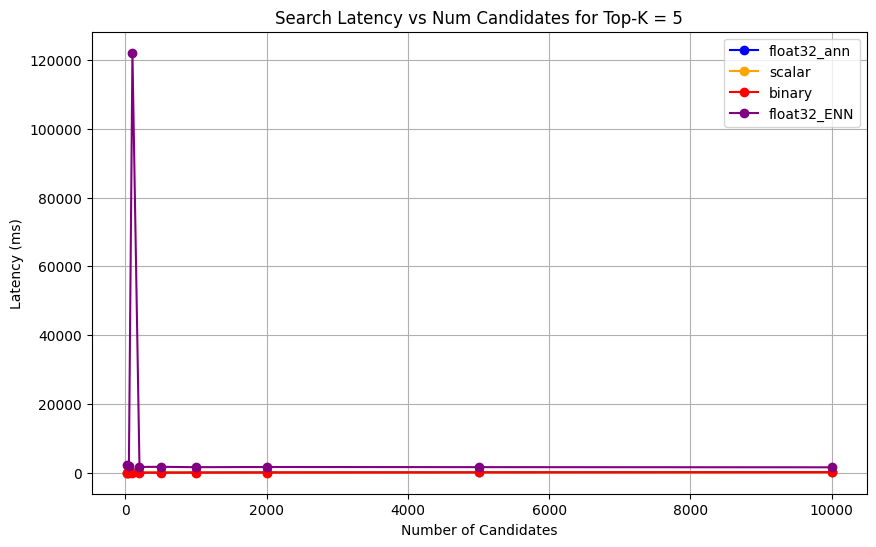

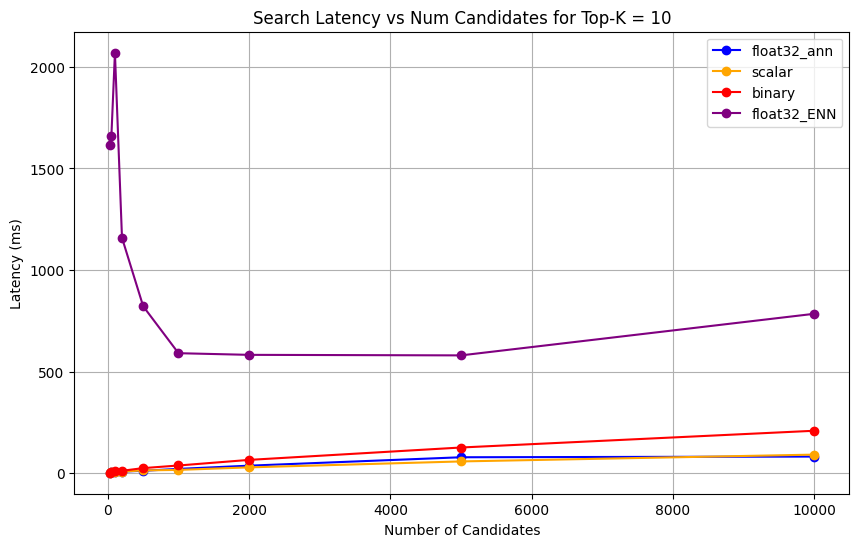

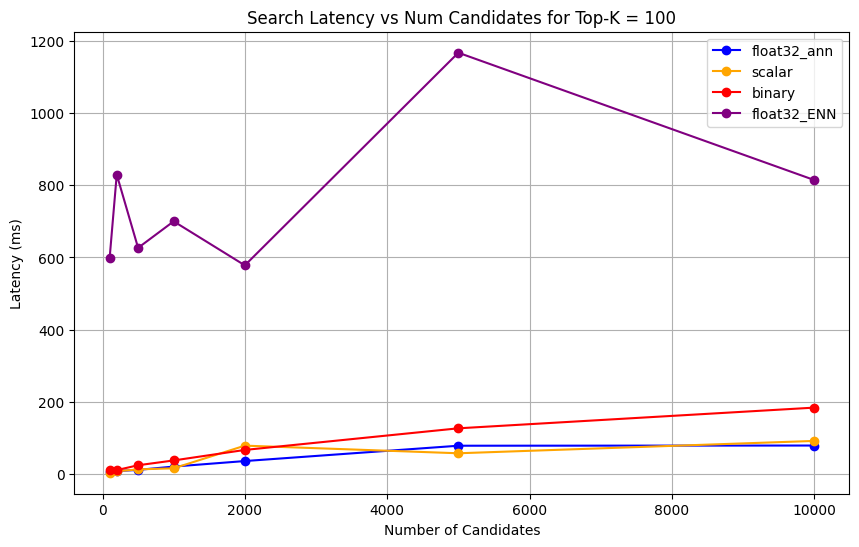

In [142]:
import matplotlib.pyplot as plt

# Map your precision field to the labels and colors you want in the legend
precision_label_map = {
    "_scalar_": "scalar",
    "_binary_": "binary",
    "_float32_ann": "float32_ann",
    "_float32_ENN": "float32_ENN",
}

precision_color_map = {
    "_scalar_": "orange",
    "_binary_": "red",
    "_float32_ann": "blue",
    "_float32_ENN": "purple",
}

# Assume latency_results is a list of lists. Each inner list corresponds to one precision type.
# Each dictionary in an inner list has keys: 'precision', 'top_k', 'num_candidates', 'latency_ms'

# Flatten all measurements and find the unique top_k values
all_measurements = [m for precision_list in latency_results for m in precision_list]
unique_topk = sorted(set(m["top_k"] for m in all_measurements))

# For each top_k, create a separate plot
for k in unique_topk:
    plt.figure(figsize=(10, 6))

    # For each precision type, filter out measurements for the current top_k value
    for measurements in latency_results:
        # Filter measurements with top_k equal to the current k
        filtered = [m for m in measurements if m["top_k"] == k]
        if not filtered:
            continue

        # Extract x (num_candidates) and y (latency) values
        x = [m["num_candidates"] for m in filtered]
        y = [m["latency_ms"] for m in filtered]

        # Determine the precision, label, and color from the first measurement in this filtered list
        precision = filtered[0]["precision"]
        label = precision_label_map.get(precision, precision)
        color = precision_color_map.get(precision, "blue")

        # Plot the line for this precision type
        plt.plot(x, y, marker="o", color=color, label=label)

    # Label axes and add title including the top_k value
    plt.xlabel("Number of Candidates")
    plt.ylabel("Latency (ms)")
    plt.title(f"Search Latency vs Num Candidates for Top-K = {k}")

    # Add a legend and grid, then show the plot
    plt.legend()
    plt.grid(True)
    plt.show()

## Step 10: Measuring Representational Capacity and Retention

In this step, we will measure the representational capacity and retention of the vector search operation.

We will use the `measure_representational_capacity_retention_against_float_enn` function to measure the representational capacity and retention of the vector search operation.

We first create the baseline search using the full precision float32 vectors and exact nearest neighbor search.

We then create the quantized search using the quantized vectors and approximate search.

We then compute the retention of the quantized search compared to the baseline search.

We should observe that retention is maintained within a reasonable range for the quantized search.

For example, if the representational capacity is low, it means that the vector search operation is not able to capture the semantic meaning of the query and the results are not accurate, which implies that the quantization is not effective, and even further implies that the initial embedding model used is not effective for the quantization process. 

This is why it's important to consider utilizing embedding models that are quantization aware, meaning that during the training process, the model is specifically optimized to produce embeddings that maintain their semantic properties even after quantization.

Quantization-aware training incorporates the quantization process directly into the training loop, allowing the model to learn parameters that minimize information loss when vectors are later compressed. This approach creates embeddings with distributions that are more resilient to quantization effects, preserving more of the critical semantic relationships between vectors even at lower bit representations.

In practice, this means the model learns to distribute information across the embedding dimensions in ways that anticipate how quantization will affect the vector space.



In [152]:
def measure_representational_capacity_retention_against_float_enn(
    ground_truth_collection,
    collection,
    quantized_index_name,  # This is used for both the quantized search and (with use_full_precision=True) for the baseline.
    top_k_values,  # List/array of top-k values to test.
    num_candidates_values,  # List/array of num_candidates values to test.
    num_queries_to_test=1,
):
    """
    For each ground truth annotation (using only question queries), perform:
      1. A full-precision (Float32) search (baseline) by setting use_full_precision=True.
      2. A quantized search (by setting use_full_precision=False).

    For each valid combination of top_k and num_candidates (where num_candidates >= top_k),
    compute retention as the fraction of baseline (Float32) results that appear in the quantized results.

    Args:
        ground_truth_collection: MongoDB collection with ground truth annotations.
        collection: The collection to search.
        quantized_index_name (str): The index name to use for both searches.
        top_k_values (list[int]): List of top-k values to test.
        num_candidates_values (list[int]): List of num_candidates values to test.
        num_queries_to_test (int): Number of ground truth annotations to test.

    Returns:
        dict: A dictionary containing:
              - "precision_name": extracted from the quantized index name,
              - "top_k_values": the list of top-k values tested,
              - "num_candidates_values": the list of num_candidates values tested,
              - "per_query_retention": retention details per query,
              - "average_retention": a dict mapping each top_k to a dict mapping num_candidates to the average retention.
    """
    retention_results = {"per_query_retention": {}}
    overall_retention = {}  # overall_retention[top_k][num_candidates] = [list of retention values]

    # Initialize overall retention structure
    for top_k in top_k_values:
        overall_retention[top_k] = {}
        for num_candidates in num_candidates_values:
            if num_candidates < top_k:
                continue
            overall_retention[top_k][num_candidates] = []

    # Extract and store the precision name from the quantized index name.
    precision_name = quantized_index_name.split("vector_index")[1]
    precision_name = precision_name.replace("quantized", "").capitalize()
    retention_results["precision_name"] = precision_name
    retention_results["top_k_values"] = top_k_values
    retention_results["num_candidates_values"] = num_candidates_values

    # Load ground truth annotations
    ground_truth_annotations = list(
        ground_truth_collection.find().limit(num_queries_to_test)
    )
    print(f"Loaded {len(ground_truth_annotations)} ground truth annotations")

    # Process each ground truth annotation
    for annotation in ground_truth_annotations:
        # Use the ground truth wiki_id from the annotation.
        ground_truth_wiki_id = annotation["wiki_id"]

        # Process only queries that are questions.
        for query_type, queries in annotation["queries"].items():
            if query_type.lower() not in ["question", "questions"]:
                continue

            for query in queries:
                # Prepare nested dict for this query
                if query not in retention_results["per_query_retention"]:
                    retention_results["per_query_retention"][query] = {}

                # For each valid combination of top_k and num_candidates
                for top_k in top_k_values:
                    if top_k not in retention_results["per_query_retention"][query]:
                        retention_results["per_query_retention"][query][top_k] = {}
                    for num_candidates in num_candidates_values:
                        if num_candidates < top_k:
                            continue

                        # Baseline search: full precision using ENN (Float32)
                        baseline_result = custom_vector_search(
                            user_query=query,
                            collection=collection,
                            embedding_path="embedding",
                            vector_search_index_name=quantized_index_name,
                            top_k=top_k,
                            num_candidates=num_candidates,
                            use_full_precision=True,
                        )
                        baseline_ids = {
                            res["wiki_id"] for res in baseline_result["results"]
                        }

                        # Quantized search:
                        quantized_result = custom_vector_search(
                            user_query=query,
                            collection=collection,
                            embedding_path="embedding",
                            vector_search_index_name=quantized_index_name,
                            top_k=top_k,
                            num_candidates=num_candidates,
                            use_full_precision=False,
                        )
                        quantized_ids = {
                            res["wiki_id"] for res in quantized_result["results"]
                        }

                        # Compute retention for this combination
                        if baseline_ids:
                            retention = len(
                                baseline_ids.intersection(quantized_ids)
                            ) / len(baseline_ids)
                        else:
                            retention = 0

                        # Store the results per query
                        retention_results["per_query_retention"][query].setdefault(
                            top_k, {}
                        )[num_candidates] = {
                            "ground_truth_wiki_id": ground_truth_wiki_id,
                            "baseline_ids": sorted(baseline_ids),
                            "quantized_ids": sorted(quantized_ids),
                            "retention": retention,
                        }
                        overall_retention[top_k][num_candidates].append(retention)

                        print(
                            f"Query: '{query}' | top_k: {top_k}, num_candidates: {num_candidates}"
                        )
                        print(f"  Ground Truth wiki_id: {ground_truth_wiki_id}")
                        print(f"  Baseline IDs (Float32): {sorted(baseline_ids)}")
                        print(
                            f"  Quantized IDs: {precision_name}: {sorted(quantized_ids)}"
                        )
                        print(f"  Retention: {retention:.4f}\n")

    # Compute overall average retention per combination
    avg_overall_retention = {}
    for top_k, cand_dict in overall_retention.items():
        avg_overall_retention[top_k] = {}
        for num_candidates, retentions in cand_dict.items():
            if retentions:
                avg = sum(retentions) / len(retentions)
            else:
                avg = 0
            avg_overall_retention[top_k][num_candidates] = avg
            print(
                f"Overall Average Retention for top_k {top_k}, num_candidates {num_candidates}: {avg:.4f}"
            )

    retention_results["average_retention"] = avg_overall_retention
    return retention_results

In [ ]:
overall_recall_results = []
top_k_values = [5, 10, 50, 100]
num_candidates_values = [25, 50, 100, 200, 500]
num_queries_to_test = 1

for vector_search_index in vector_search_indicies:
    overall_recall_results.append(
        measure_representational_capacity_retention_against_float_enn(
            ground_truth_collection=wiki_annotation_data_collection,
            collection=wiki_data_collection,
            quantized_index_name=vector_search_index,
            top_k_values=top_k_values,
            num_candidates_values=num_candidates_values,
            num_queries_to_test=num_queries_to_test,
        )
    )

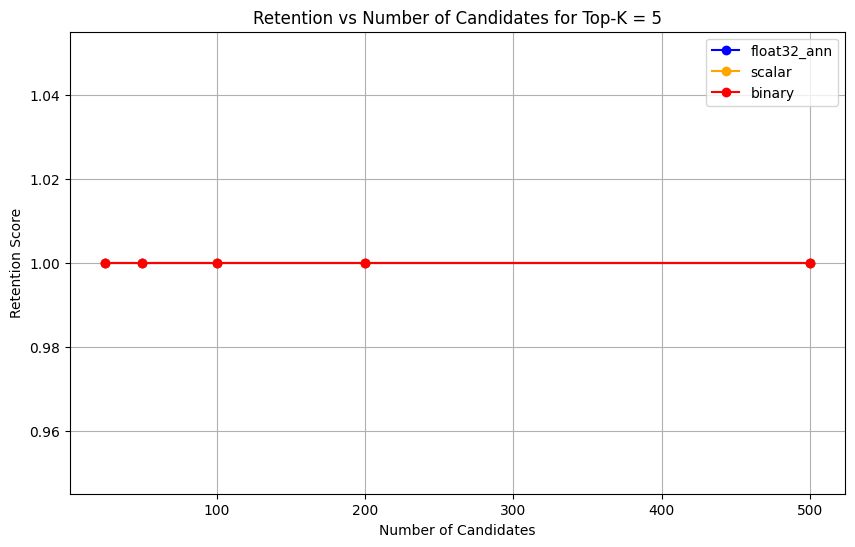

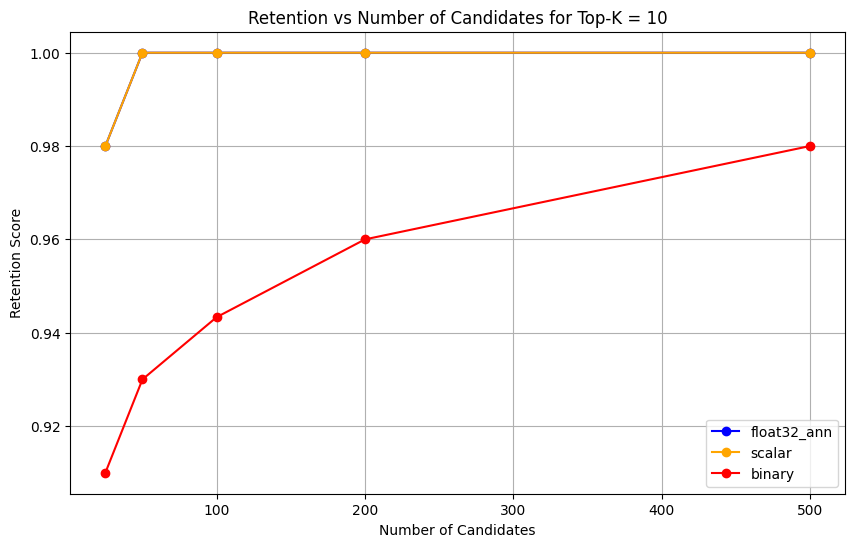

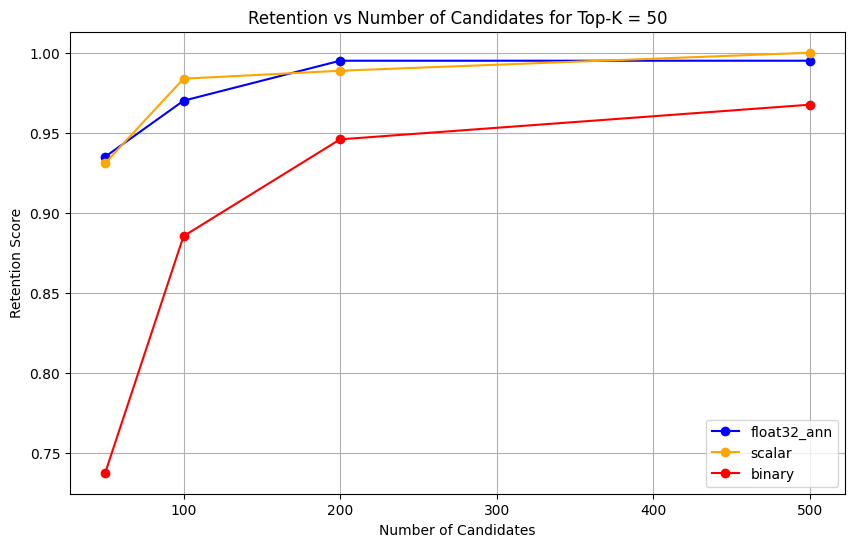

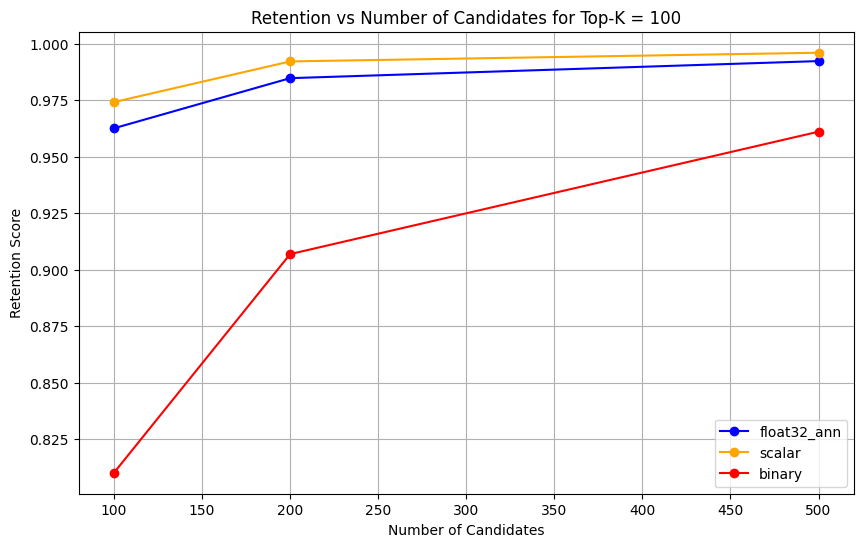


Detailed Average Retention Results:

_float32_ann Embedding:

Top-K: 5
   NumCandidates: 25, Retention: 1.0000
   NumCandidates: 50, Retention: 1.0000
   NumCandidates: 100, Retention: 1.0000
   NumCandidates: 200, Retention: 1.0000
   NumCandidates: 500, Retention: 1.0000

Top-K: 10
   NumCandidates: 25, Retention: 0.9800
   NumCandidates: 50, Retention: 1.0000
   NumCandidates: 100, Retention: 1.0000
   NumCandidates: 200, Retention: 1.0000
   NumCandidates: 500, Retention: 1.0000

Top-K: 50
   NumCandidates: 50, Retention: 0.9350
   NumCandidates: 100, Retention: 0.9700
   NumCandidates: 200, Retention: 0.9950
   NumCandidates: 500, Retention: 0.9950

Top-K: 100
   NumCandidates: 100, Retention: 0.9626
   NumCandidates: 200, Retention: 0.9847
   NumCandidates: 500, Retention: 0.9923

_scalar_ Embedding:

Top-K: 5
   NumCandidates: 25, Retention: 1.0000
   NumCandidates: 50, Retention: 1.0000
   NumCandidates: 100, Retention: 1.0000
   NumCandidates: 200, Retention: 1.0000
   NumCan

In [156]:
import matplotlib.pyplot as plt

# Define colors and labels for each precision type
precision_colors = {"_scalar_": "orange", "_binary_": "red", "_float32_": "green"}

# Assume overall_retention_results is a list of dictionaries returned by your
# measure_representational_capacity_retention_against_float_enn function.
# Each dictionary should contain:
#   - 'precision_name': the precision type (e.g., '_scalar_')
#   - 'average_retention': a dict mapping each top_k to a dict mapping num_candidates
#                           to the average retention, e.g.,
#                           average_retention[top_k][num_candidates] = retention_value

if overall_recall_results:
    # Determine unique top_k values from the first result's average_retention keys
    unique_topk = sorted(list(overall_recall_results[0]["average_retention"].keys()))

    for k in unique_topk:
        plt.figure(figsize=(10, 6))
        # For each precision type, plot retention vs. number of candidates at this top_k
        for result in overall_recall_results:
            precision_name = result.get("precision_name", "unknown")
            color = precision_colors.get(precision_name, "blue")
            # Get candidate values from the average_retention dictionary for top_k k
            candidate_values = sorted(result["average_retention"][k].keys())
            retention_values = [
                result["average_retention"][k][nc] for nc in candidate_values
            ]

            plt.plot(
                candidate_values,
                retention_values,
                marker="o",
                label=precision_name.strip("_"),
                color=color,
            )

        plt.xlabel("Number of Candidates")
        plt.ylabel("Retention Score")
        plt.title(f"Retention vs Number of Candidates for Top-K = {k}")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Print detailed average retention results
    print("\nDetailed Average Retention Results:")
    for result in overall_recall_results:
        precision_name = result.get("precision_name", "unknown")
        print(f"\n{precision_name} Embedding:")
        for k in sorted(result["average_retention"].keys()):
            print(f"\nTop-K: {k}")
            for nc in sorted(result["average_retention"][k].keys()):
                ret = result["average_retention"][k][nc]
                print(f"   NumCandidates: {nc}, Retention: {ret:.4f}")

In this guide, we demonstrate how to leverage MongoDB Atlas Search with automatic quantization and Voyage AI embeddings to build a scalable, high-performance vector search pipeline. By compressing the embedding space—whether through scalar or binary quantization—you can dramatically reduce memory usage while retaining the vast majority of retrieval accuracy compared to a float32 baseline. 

These techniques not only cut operational costs but also improve throughput, allowing you to handle larger workloads or more complex queries. 

Furthermore, MongoDB Atlas’s integration of indexing, querying, and storage provides a unified environment for rapid prototyping, testing, and production deployment, all backed by robust, enterprise-ready infrastructure.